# Orlando

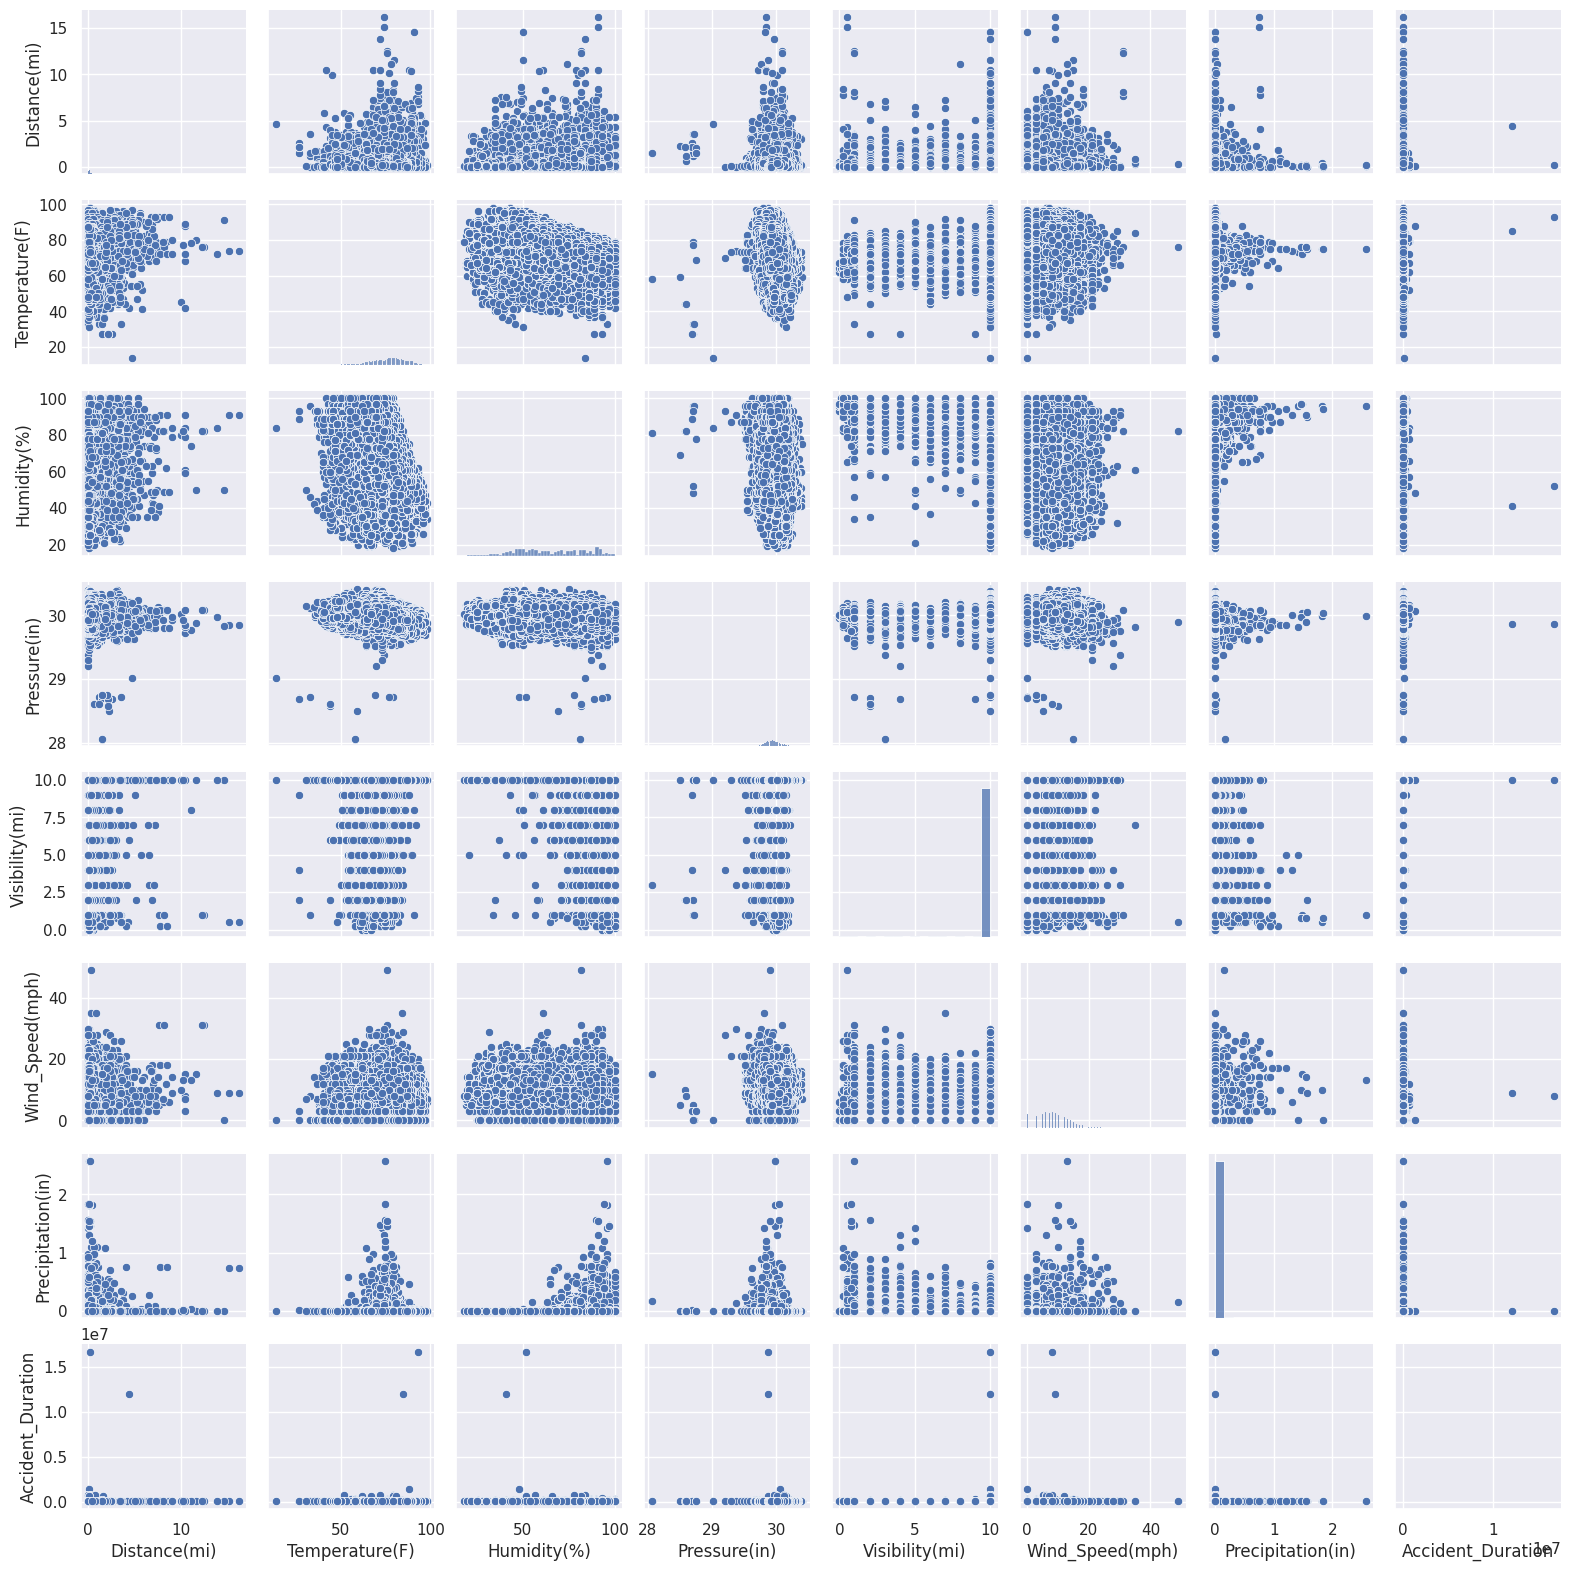

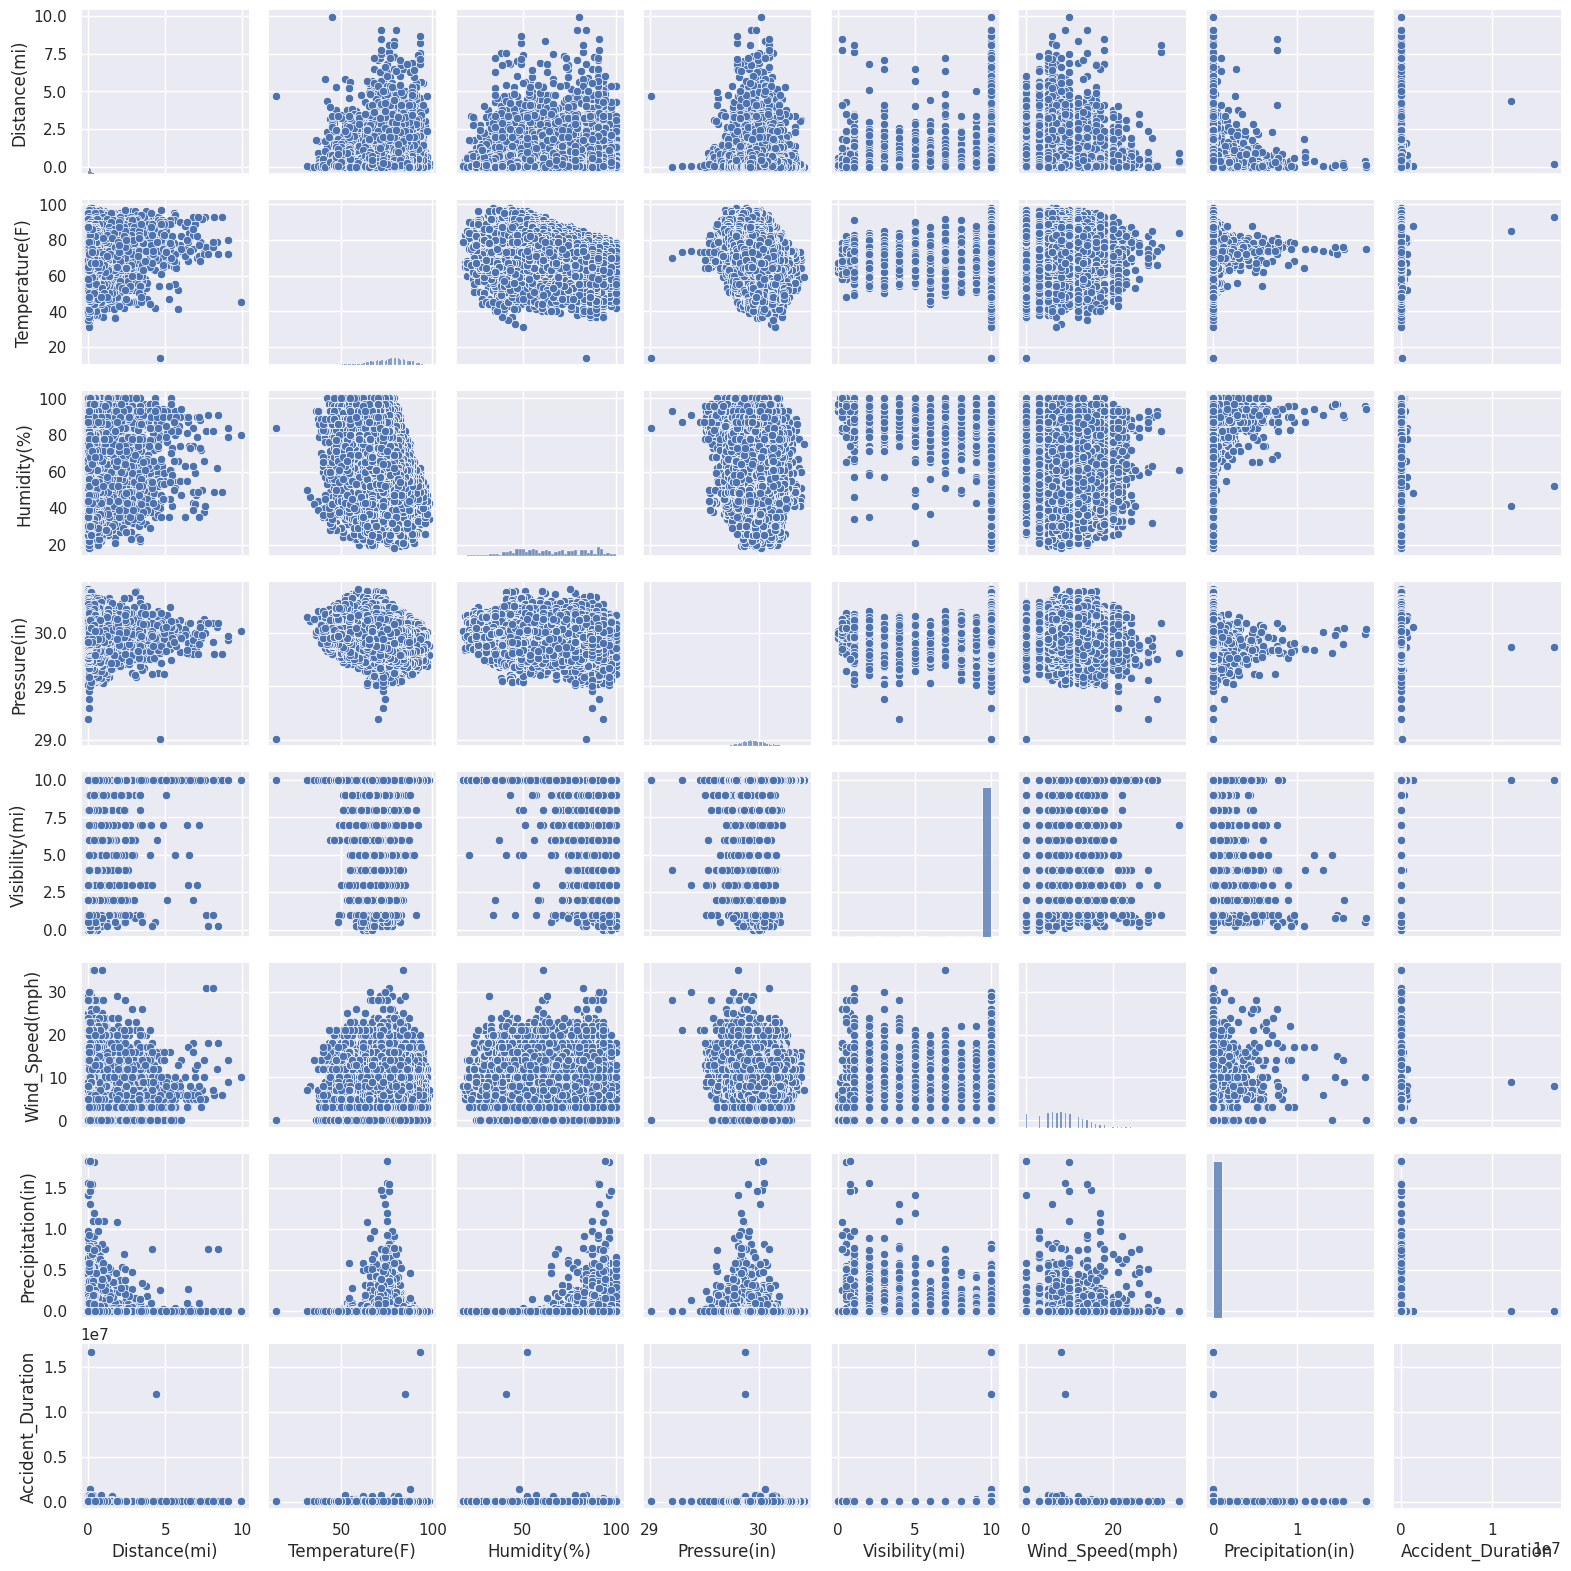

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.read_csv("Orlando_accidents.csv").sort_values("Start_Time")
df = df.drop(["Accident_Duration_Hours","Accident_Duration_Minutes","Accident_Duration_Seconds","Wind_Chill(F)"],axis=1)
df.drop(["Start_Lat","Start_Lng","End_Lat","End_Lng"],axis=1).describe()
categorical_df = df.select_dtypes(include=["object"])
numerical_df = df.select_dtypes(include=["float64","int64"])
bool_df = df.select_dtypes(include=["bool"]) * 1 
numerical_df = numerical_df.fillna(method="backfill")
df = categorical_df.join(numerical_df).join(bool_df).reset_index(drop=True)

sns.set(rc = {'figure.figsize':(20,10)})
cols = ['Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Accident_Duration']
sns.pairplot(df[cols], size = 2)
plt.show();
df = df.drop(df[df["Distance(mi)"]>10].index)
df = df.drop(df[df["Pressure(in)"]<29].index)
df = df.drop(df[df["Wind_Speed(mph)"]>40].index)
df = df.drop(df[df["Precipitation(in)"]>2].index)
sns.set(rc = {'figure.figsize':(20,10)})
cols = ['Distance(mi)','Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Accident_Duration']
sns.pairplot(df[cols], size = 2)
plt.show();

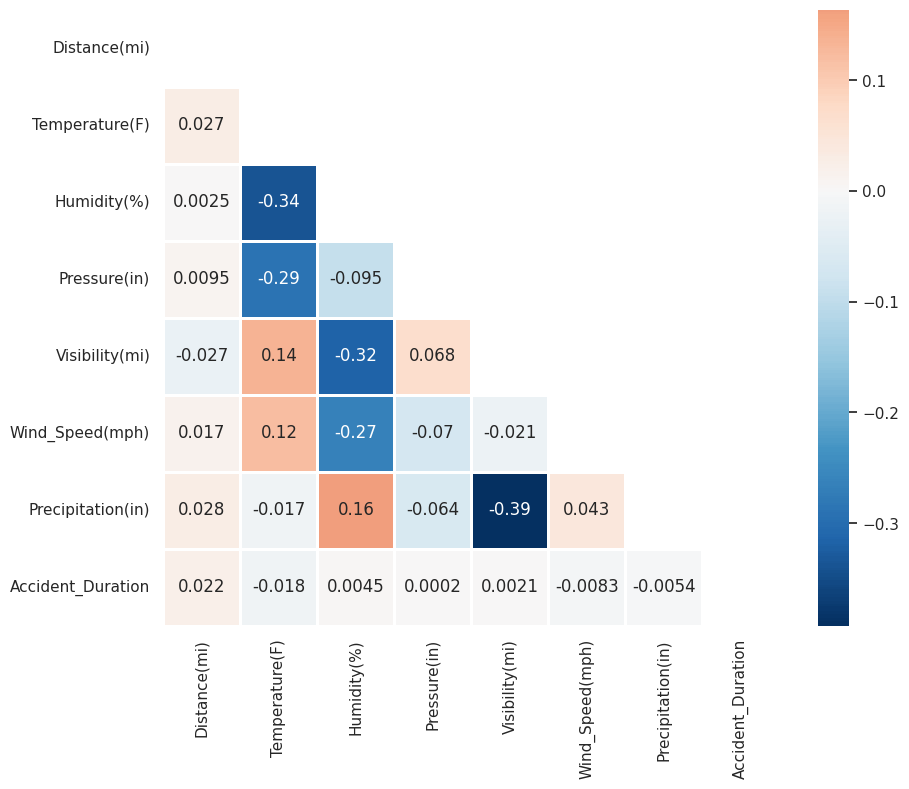

In [ ]:
mask = np.zeros_like(df[cols].corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (10,8))
sns.heatmap(df[cols].corr(),annot=True,mask = mask,cmap = 'RdBu_r',linewidths=.9,linecolor='white', fmt='.2g',center = 0,square=True);

In [ ]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

include_cols = ['Airport_Code','Wind_Direction','Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Severity','Distance(mi)', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way','Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop','Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Year','Month','Day','Hour','Weekday']
X = df[include_cols]
y = df['Accident_Duration']
X = pd.get_dummies(X,drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_std = scalar.fit_transform(X_train) 
X_test_std = scalar.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

rf_params = {'max_depth': randint(1,20), 'min_samples_split': randint(2, 10), 'min_samples_leaf': randint(1, 4)}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, cv=3, random_state=42, n_jobs=-1)
rf_random.fit(X_train_std,y_train)
best_params = rf_random.best_params_
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train_std, y_train)
y_pred_rf = best_rf.predict(X_test_std)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("rmse:",rmse_rf)
print("r2:",r2_rf)

rmse: 28084.284259124805
r2: -0.6439084896185621


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_nn_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_std.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

nn_model = KerasRegressor(build_fn=build_nn_model, epochs=50, batch_size=10, verbose=0)
nn_model.fit(X_train_std, y_train)
y_pred_nn = nn_model.predict(X_test_std)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("rmse:",rmse_nn)
print("r2:",r2_nn)

2023-12-06 00:02:50.639509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 00:02:50.980132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-06 00:02:50.980179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-06 00:02:51.013622: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 00:02:52.889698: W tensorflow/stream_executor/platform/de

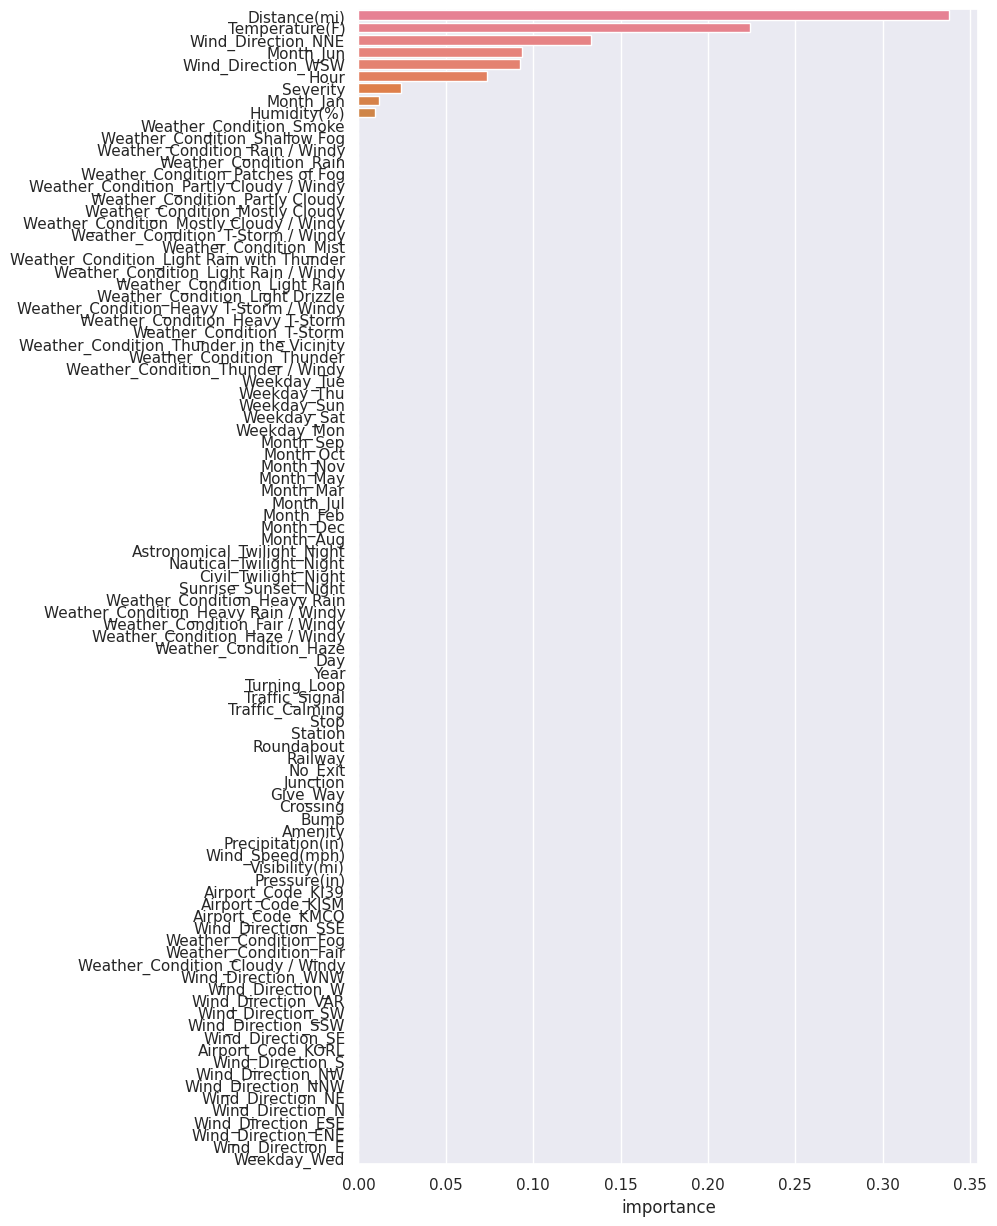

In [ ]:
feature_importances = pd.DataFrame(best_rf.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

sns.set(rc = {'figure.figsize':(8,15)})
sns.barplot(y=feature_importances.index,x="importance",data=feature_importances,palette="husl");

# Los Angeles

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import FuncFormatter

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

la = pd.read_csv("Los Angeles_accidents.csv")

In [ ]:
la.info()

In [ ]:
la.describe()

In [ ]:
la = la.drop(columns = ['ID', 'Source', 'End_Time', 'End_Lat', 'End_Lng', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Turning_Loop', 'Nautical_Twilight', 'Civil_Twilight', 'Astronomical_Twilight', 'Accident_Duration_Hours', 'Accident_Duration_Minutes', 'Accident_Duration_Seconds'])

In [ ]:
categorical_features = ['Severity', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Traffic_Calming', 'Traffic_Signal']

fig, axes = plt.subplots(4, 3, figsize = (15, 15), sharex = False, sharey = False)

count = 0
for col in categorical_features:
    value_counts = la[col].value_counts()
    x = count // 3
    y = count % 3
    sns.barplot(ax = axes[x, y], x = value_counts.index, y = value_counts.values)
    axes[x, y].set_title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

In [ ]:
sns.barplot(x = la['Sunrise_Sunset'].value_counts().index, y = la['Sunrise_Sunset'].value_counts().values)
plt.title('Sunrise_Sunset');

In [ ]:
sns.barplot(x = la['Stop'].value_counts().index, y = la['Stop'].value_counts().values)
plt.title('Stop');

In [ ]:
numerical_features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
 
fig, axes = plt.subplots(2, 3, figsize = (15, 15), sharex = False, sharey = False)

count = 0
for col in numerical_features:
    x = count // 3
    y = count % 3
    sns.histplot(ax = axes[x, y], data = la, x = col)
    axes[x, y].set_title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

In [ ]:
sns.histplot(data = la, x = 'Precipitation(in)')
plt.title('Precipitation(in)');

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(la.dropna().corr(method = 'pearson'), annot = True)
plt.show()

In [ ]:
la.isnull().sum()

In [ ]:
temp_mean = la['Temperature(F)'].mean()
wind_chill_mean = la['Wind_Chill(F)'].mean()
humid_mean = la['Humidity(%)'].mean()
pressure_mean = la['Pressure(in)'].mean()
visibility_mean = la['Visibility(mi)'].mean()
wind_mean = la['Wind_Speed(mph)'].mean()
precipitation_mean = la['Precipitation(in)'].mean()

la['Temperature(F)'] = la['Temperature(F)'].fillna(temp_mean)
la['Wind_Chill(F)'] = la['Wind_Chill(F)'].fillna(wind_chill_mean)
la['Humidity(%)'] = la['Humidity(%)'].fillna(humid_mean)
la['Pressure(in)'] = la['Pressure(in)'].fillna(pressure_mean)
la['Visibility(mi)'] = la['Visibility(mi)'].fillna(visibility_mean)
la['Wind_Speed(mph)'] = la['Wind_Speed(mph)'].fillna(wind_mean)
la['Precipitation(in)'] = la['Precipitation(in)'].fillna(precipitation_mean)

In [ ]:
la.isnull().sum()

In [ ]:
wind_direction_mode = la['Wind_Direction'].mode()[0]
weather_mode = la['Weather_Condition'].mode()[0]

la['Wind_Direction'] = la['Wind_Direction'].fillna(wind_direction_mode)
la['Weather_Condition'] = la['Weather_Condition'].fillna(weather_mode)

In [ ]:
la.isnull().sum()

In [ ]:
# Convert those weather condition that has less than 100 counts to other (group them together)
counts = la['Weather_Condition'].value_counts()
idx = counts[counts.lt(100)].index

la.loc[la['Weather_Condition'].isin(idx), 'Weather_Condition'] = 'Other'

la['Weather_Condition'].value_counts()

In [ ]:
def to_datetime(row):
    time_format = "%Y-%m-%d %H:%M:%S"

    if len(row["Start_Time"]) == 19:
        dt = datetime.strptime(row["Start_Time"], time_format)
    
    elif len(row["Start_Time"]) == 26:
        dt = datetime.strptime(row["Start_Time"][:-7], time_format)
    
    elif len(row["Start_Time"]) == 29:
        dt = datetime.strptime(row["Start_Time"][:-10], time_format)
    
    return dt

# Get Day of Accident
la["Time_of_Incident"] = la.apply(lambda x: to_datetime(x), axis = 1)
la["Day"] = la.apply(lambda x: x.Time_of_Incident.day_name(), axis = 1)

# Get the decimal points of latitude and longtitude so it can be more sensitive to the model for location
la['Lat_Decimal'] = la.Start_Lat.astype(str).str.extract('\.(.*)').astype(int)
la['Lng_Decimal'] = la.Start_Lng.astype(str).str.extract('\.(.*)').astype(int)

la.head()

In [ ]:
sns.barplot(x = la['Day'].value_counts().index, y = la['Day'].value_counts().values)
plt.title('Day');

In [ ]:
# Converting Duration to categorys

# 15 mins or less = 0
# 15 - 30mins = 1
# 30 mins - 1hr = 2
# 1 - 3hr = 3
# 3hr - 6hr = 4
# rest of day = 5

la['ETA'] = 0
la.loc[la['Accident_Duration'] <= 900, 'ETA'] = 0 
la.loc[(la['Accident_Duration'] <= 1800) & (la['Accident_Duration'] > 900), 'ETA'] = 1
la.loc[(la['Accident_Duration'] <= 3600) & (la['Accident_Duration'] > 1800), 'ETA'] = 2
la.loc[(la['Accident_Duration'] <= 10800) & (la['Accident_Duration'] > 3600), 'ETA'] = 3
la.loc[(la['Accident_Duration'] <= 21600) & (la['Accident_Duration'] > 10800), 'ETA'] = 4
la.loc[la['Accident_Duration'] > 21600, 'ETA'] = 5

In [ ]:
le = LabelEncoder()

la['Weather_Condition'] = le.fit_transform(la['Weather_Condition'])
la['Wind_Direction'] = le.fit_transform(la['Wind_Direction'])
la['Day'] = le.fit_transform(la['Day'])

cols = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Stop']

ohe = OneHotEncoder()
array_hot_encoded = ohe.fit_transform(la[cols]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = ohe.get_feature_names_out(), index=la.index)
data_other_cols = la.drop(columns = cols)
cleaned_la = pd.concat([data_hot_encoded, data_other_cols], axis=1)

cleaned_la.head()

In [ ]:
y = cleaned_la['Accident_Duration']
X = cleaned_la.drop(['Accident_Duration', 'Start_Time', 'Time_of_Incident', 'ETA'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

compare_regression = pd.DataFrame(y_test)
compare_regression.rename(columns = {'Accident_Duration' : 'Actual'}, inplace = True)
compare_regression['Predicted'] = y_pred
compare_regression['80% Actual'] = 0.8 * compare_regression['Actual']
compare_regression['120% Actual'] = 1.2 * compare_regression['Actual']
compare_regression['Good_Prediction'] = compare_regression['Predicted'].between(compare_regression['80% Actual'], compare_regression['120% Actual'])
compare_regression['Good_Prediction'].value_counts()

In [ ]:
clf = MLPRegressor(hidden_layer_sizes = (10), solver = 'lbfgs', max_iter = 10000, random_state = 42)
clf.fit(X_train, y_train)

y_pred_mlp = clf.predict(X_test)

print("Train:", clf.score(X_train, y_train))
print("Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred_mlp))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))

compare_mlp = pd.DataFrame(y_test)
compare_mlp.rename(columns = {'Accident_Duration' : 'Actual'}, inplace = True)
compare_mlp['Predicted'] = y_pred_mlp
compare_mlp['80% Actual'] = 0.8 * compare_mlp['Actual']
compare_mlp['120% Actual'] = 1.2 * compare_mlp['Actual']
compare_mlp['Good_Prediction'] = compare_mlp['Predicted'].between(compare_mlp['80% Actual'], compare_mlp['120% Actual'])
compare_mlp['Good_Prediction'].value_counts()

In [ ]:
# Attemping Classifier as we don't need to know the exact time it will take to clear the accident, but generally a sense of it (binned duration to relevant categories)
y = cleaned_la['ETA']
X = cleaned_la.drop(['Accident_Duration', 'Start_Time', 'Time_of_Incident', 'ETA'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
mlp_class = MLPClassifier(hidden_layer_sizes = (10), activation = 'logistic', solver = 'lbfgs', max_iter = 10000, random_state = 42)

mlp_class.fit(X_train, y_train)

y_pred_test = mlp_class.predict(X_test)
print(accuracy_score(y_test, y_pred_test))

In [ ]:
# Depth 3
features = X
records = features.to_dict('records')
label = la['ETA']

vec = DictVectorizer()
feature_data = vec.fit_transform(records).toarray()

d_tree = DecisionTreeClassifier(max_depth = 3, random_state = 42)
d_tree = d_tree.fit(feature_data, label)
print(d_tree.score(feature_data, label))

In [ ]:
# Depth 5
d_tree = DecisionTreeClassifier(max_depth = 5, random_state = 42)
d_tree = d_tree.fit(feature_data, label)
print(d_tree.score(feature_data, label))

In [ ]:
# Depth 10
d_tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
d_tree = d_tree.fit(feature_data, label)
print(d_tree.score(feature_data, label))

In [ ]:
clf_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_forest.fit(X_train, y_train)

y_pred_forest = clf_forest.predict(X_test)
print(accuracy_score(y_test, y_pred_forest))

In [ ]:
importances = clf_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index = X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# After removing less important features
y = cleaned_la['ETA']
X = cleaned_la[['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Day', 'Lat_Decimal', 'Lng_Decimal']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
clf_forest_2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_forest_2.fit(X_train, y_train)

y_pred_forest_2 = clf_forest_2.predict(X_test)
print(accuracy_score(y_test, y_pred_forest_2))

In [ ]:
params = {
    "max_depth" : range(2, 20, 4),
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid = params, cv = 3)
grid_search.fit(feature_data_train_2, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

y_pred_tree_3 = grid_search.predict(features_data_test_2)
accuracy_score(y_test, y_pred_tree_3)

In [ ]:
mlp_class_2 = MLPClassifier(hidden_layer_sizes = (10), activation = 'logistic', solver = 'lbfgs', max_iter = 10000, random_state = 42)

mlp_class_2.fit(X_train, y_train)

y_pred_test_2 = mlp_class_2.predict(X_test)
print(accuracy_score(y_test, y_pred_test_2))

In [ ]:
x = np.arange(6)
accuracy = [48.9, 63.0, 61.3, 61.4, 56.2, 48.9]

def millions(x, pos):
    'The two args are the value and tick position'
    return (x )

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize = (15, 10))
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, accuracy)
plt.xticks(x, ('MLP', 'DTree', 'RForest', 'RForest(less features)', 'DTree(less features)', 'MLP(less features)'))
plt.title('Classification Models')
plt.show()

In [ ]:
x = np.arange(2)
accuracy = [279 / 13836, 3023 / 13836]

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, accuracy)
plt.xticks(x, ('MLP', 'LinearR'))
plt.title('Regression Models')
plt.show()

# Charlotte

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
charlotte = pd.read_csv('Charlotte_accidents.csv')

In [ ]:
df = charlotte.copy()

In [ ]:
#drop 
df = df.drop(columns=['Wind_Direction', 'Start_Lat', 'Start_Lng', 'End_Time','Weather_Timestamp', 'End_Lat', 'End_Lng', 'City', 'State', 'Street', 'Country', 'Timezone', 
                      'Airport_Code', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight', 'Accident_Duration_Hours', 'Accident_Duration_Minutes', 'Accident_Duration_Seconds'])

In [ ]:
df = df.dropna()

In [ ]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Start_Time'] = df['Start_Time'].dt.hour

In [ ]:
# List of keywords to check for
keywords = ['blocked', 'delays', 'I-', 'NC-', 'ST']

for keyword in keywords:
    df[keyword.lower()] = df['Description'].str.contains(keyword, case=False)
df

,ID,Source,Severity,Start_Time,Distance(mi),Description,County,Zipcode,Temperature(F),Wind_Chill(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,Accident_Duration,blocked,delays,i-,nc-,st
0,A-512254,Source2,1,6,0.000,Lane blocked due to crash on Quality Dr at Wes...,Mecklenburg,28278-8737,70.0,70.0,...,False,False,False,Night,4671.0,True,False,False,False,True
1,A-512255,Source2,1,6,0.000,Lane blocked due to crash on Pheasant Chase Ln...,Mecklenburg,28216-3294,69.0,69.0,...,False,False,False,Night,4464.0,True,False,False,False,False
2,A-512256,Source2,1,6,0.000,Crash on NC-16 Brookshire Blvd at Mt Holly-Hun...,Mecklenburg,28214,69.0,69.0,...,False,True,False,Night,3529.0,False,False,False,True,False
3,A-512285,Source2,1,6,0.000,Crash on Mt Holly-Huntersville Rd at Chastain ...,Mecklenburg,28216-7662,69.0,69.0,...,False,False,False,Day,1745.0,False,False,False,False,True
4,A-512332,Source2,1,5,0.000,Crash on Tuckaseegee Rd at Jay St.,Mecklenburg,28208,70.0,70.0,...,False,False,False,Night,1902.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39145,A-6940750,Source1,2,3,0.056,Incident on N TRYON ST near ORR RD Expect delays.,Mecklenburg,28213,52.0,52.0,...,False,True,False,Night,8896.0,False,True,False,False,True
39146,A-6942034,Source1,2,6,0.089,Incident on E 5TH ST near N TRYON ST Expect de...,Mecklenburg,28202-2136,54.0,54.0,...,False,False,False,Night,7372.0,False,True,False,False,True
39147,A-6942832,Source1,2,2,0.010,Incident on ASHLEY RD near FREEDOM DR Drive wi...,Mecklenburg,28208-2819,53.0,53.0,...,False,True,False,Night,7946.0,False,False,False,False,False
39148,A-6951033,Source1,2,2,0.625,Incident on I-77 near W ARROWOOD RD Expect del...,Mecklenburg,28273,53.0,53.0,...,False,False,False,Night,4726.0,False,True,True,False,False


In [ ]:
# Trimming
trim_percentage = 5

# Identify the lower and upper quantiles for trimming
lower_quantile = trim_percentage / 100
upper_quantile = 1 - (trim_percentage / 100)

numeric_columns = df.select_dtypes(include='number')
row_mask = (numeric_columns >= numeric_columns.quantile(lower_quantile)) & (numeric_columns <= numeric_columns.quantile(upper_quantile))
row_mask = row_mask.all(axis=1)

df = df[row_mask]
df

,ID,Source,Severity,Start_Time,Distance(mi),Description,County,Zipcode,Temperature(F),Wind_Chill(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Civil_Twilight,Accident_Duration,blocked,delays,i-,nc-,st
0,A-512254,Source2,1,6,0.000,Lane blocked due to crash on Quality Dr at Wes...,Mecklenburg,28278-8737,70.0,70.0,...,False,False,False,Night,4671.0,True,False,False,False,True
1,A-512255,Source2,1,6,0.000,Lane blocked due to crash on Pheasant Chase Ln...,Mecklenburg,28216-3294,69.0,69.0,...,False,False,False,Night,4464.0,True,False,False,False,False
2,A-512256,Source2,1,6,0.000,Crash on NC-16 Brookshire Blvd at Mt Holly-Hun...,Mecklenburg,28214,69.0,69.0,...,False,True,False,Night,3529.0,False,False,False,True,False
3,A-512285,Source2,1,6,0.000,Crash on Mt Holly-Huntersville Rd at Chastain ...,Mecklenburg,28216-7662,69.0,69.0,...,False,False,False,Day,1745.0,False,False,False,False,True
4,A-512332,Source2,1,5,0.000,Crash on Tuckaseegee Rd at Jay St.,Mecklenburg,28208,70.0,70.0,...,False,False,False,Night,1902.0,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39095,A-6569235,Source1,2,9,0.023,Incident on PARK RD near SENECA PL Drive with ...,Mecklenburg,28209-3274,40.0,34.0,...,False,True,False,Day,11174.0,False,False,False,False,False
39102,A-6569515,Source1,2,6,0.202,Incident on OAKDALE RD near KELLY RD Drive wit...,Mecklenburg,28216-1482,37.0,33.0,...,False,False,False,Night,6073.0,False,False,False,False,False
39105,A-6569846,Source1,2,18,0.142,Incident on RUNNYMEDE LN near WINDSOR DR Drive...,Mecklenburg,28209,46.0,46.0,...,False,False,False,Night,9661.0,False,False,False,False,False
39107,A-6570617,Source1,2,13,0.026,Incident on N SARDIS RD near GALLERIA VILLAGE ...,Mecklenburg,28270-2402,67.0,67.0,...,False,False,False,Day,8487.0,False,False,False,False,False


In [ ]:
boolean_columns = df.select_dtypes(include='bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)
df

,ID,Source,Severity,Start_Time,Distance(mi),Description,County,Zipcode,Temperature(F),Wind_Chill(F),...,blocked,delays,i-,nc-,st,Weather_Cloudy,Weather_Fair,Weather_Mostly Cloudy,Weather_Other,Weather_Partly Cloudy
0,A-512254,Source2,1,6,0.000,Lane blocked due to crash on Quality Dr at Wes...,Mecklenburg,28278-8737,70.0,70.0,...,1,0,0,0,1,1,0,0,0,0
1,A-512255,Source2,1,6,0.000,Lane blocked due to crash on Pheasant Chase Ln...,Mecklenburg,28216-3294,69.0,69.0,...,1,0,0,0,0,0,0,1,0,0
2,A-512256,Source2,1,6,0.000,Crash on NC-16 Brookshire Blvd at Mt Holly-Hun...,Mecklenburg,28214,69.0,69.0,...,0,0,0,1,0,0,0,1,0,0
3,A-512285,Source2,1,6,0.000,Crash on Mt Holly-Huntersville Rd at Chastain ...,Mecklenburg,28216-7662,69.0,69.0,...,0,0,0,0,1,0,0,1,0,0
4,A-512332,Source2,1,5,0.000,Crash on Tuckaseegee Rd at Jay St.,Mecklenburg,28208,70.0,70.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39095,A-6569235,Source1,2,9,0.023,Incident on PARK RD near SENECA PL Drive with ...,Mecklenburg,28209-3274,40.0,34.0,...,0,0,0,0,0,0,1,0,0,0
39102,A-6569515,Source1,2,6,0.202,Incident on OAKDALE RD near KELLY RD Drive wit...,Mecklenburg,28216-1482,37.0,33.0,...,0,0,0,0,0,1,0,0,0,0
39105,A-6569846,Source1,2,18,0.142,Incident on RUNNYMEDE LN near WINDSOR DR Drive...,Mecklenburg,28209,46.0,46.0,...,0,0,0,0,0,0,1,0,0,0
39107,A-6570617,Source1,2,13,0.026,Incident on N SARDIS RD near GALLERIA VILLAGE ...,Mecklenburg,28270-2402,67.0,67.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
target_column = 'Accident_Duration'
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
correlations = correlation_matrix[target_column].drop(target_column)
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

blocked                  0.254254
Distance(mi)             0.243359
Traffic_Signal           0.223407
Severity                 0.221620
delays                   0.145592
Humidity(%)              0.096498
Start_Time               0.066515
Crossing                 0.065914
Wind_Speed(mph)          0.059779
i-                       0.049600
st                       0.043487
nc-                      0.040067
Railway                  0.038666
Weather_Other            0.026133
Give_Way                 0.025822
No_Exit                  0.017515
Wind_Chill(F)            0.014772
Visibility(mi)           0.014406
Temperature(F)           0.014126
Weather_Partly Cloudy    0.011535
Stop                     0.011408
Weather_Cloudy           0.010668
Amenity                  0.008568
Bump                     0.008416
Station                  0.007940
Weather_Mostly Cloudy    0.006715
Traffic_Calming          0.006568
Junction                 0.005845
Pressure(in)             0.005576
Precipitation(

In [ ]:
from sklearn.ensemble import RandomForestRegressor

a = df.drop(columns=['ID', 'Description', 'Zipcode'])

categorical_columns = a.select_dtypes(include=['object']).columns

# Select only categorical columns
X_categorical = a[categorical_columns]

X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)
X_combined = pd.concat([a.drop(categorical_columns, axis=1), X_categorical_encoded], axis=1)

# Split the data into features and target
X = X_combined.drop('Accident_Duration', axis=1)  # Updated target column
y = X_combined['Accident_Duration']

# Use RandomForestRegressor for feature importance
rf = RandomForestRegressor()
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features_rf = feature_importances[feature_importances > 0.05].index
selected_features_rf

Index(['Start_Time', 'Distance(mi)', 'Humidity(%)', 'Pressure(in)',
       'Wind_Speed(mph)'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def within_percentage(y_true, y_pred, percentage=10):
    lower_bound = (100 - percentage) / 100.0 * y_true
    upper_bound = (100 + percentage) / 100.0 * y_true
    within_range = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    return within_range.mean()

target_column = 'Accident_Duration'
selected_features = ['Junction', 'blocked', 'Distance(mi)', 'Temperature(F)', 'Traffic_Signal', 
'delays', 'Start_Time', 'Humidity(%)', 'Pressure(in)', 'Crossing', 'Wind_Speed(mph)']

y = df[target_column]
X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

accuracy_within_10_percent = within_percentage(y_test, y_pred, percentage=10)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy within 10%: {accuracy_within_10_percent}')

Mean Squared Error: 3151851.6464602766
R-squared: 0.5071566021510971
Accuracy within 10%: 0.3305500982318271


In [ ]:
from sklearn.linear_model import LinearRegression

target_column = 'Accident_Duration'
selected_features = ['Junction', 'blocked', 'Distance(mi)', 'Temperature(F)', 'Traffic_Signal', 'delays', 
'Start_Time', 'Humidity(%)', 'Pressure(in)', 'Crossing', 'Wind_Speed(mph)']

y = df[target_column]
X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

accuracy_within_10_percent = within_percentage(y_test, y_pred, percentage=10)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy within 10%: {accuracy_within_10_percent}')

Mean Squared Error: 5490738.25595842
R-squared: 0.14143354373782324
Accuracy within 10%: 0.13064833005893908


# Houston

In [ ]:
import numpy as np 
import pandas as pd
df = pd.read_csv("/kaggle/input/houston-accidents/Houston_accidents.csv")
df = df[df.State == "TX"]
df = df.drop(columns=[
    'ID',                             
    'Source', 
    'Description',    
    'End_Time',  
    'Street',    
    'City',    
    'County',    
    'State',     
    'Country',    
    'Timezone',
    "Weather_Condition",
    "Wind_Direction",
])

In [ ]:
# Additional Feature Engineering
import datetime as dt
df["Start_Time"] = pd.to_datetime(df["Start_Time"])
df["Start_Time"] = df["Start_Time"].map(dt.datetime.toordinal)
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])
df['Weather_Timestamp'] = df['Weather_Timestamp'].map(dt.datetime.toordinal)
df["Zipcode"] = df["Zipcode"].str[:5]

# One Hot Encoding
one_hot_cols = [
    "Sunrise_Sunset",
    "Civil_Twilight",
    "Nautical_Twilight",
    "Astronomical_Twilight",
    "Airport_Code"
]
for _ in one_hot_cols:
    df = pd.get_dummies(df, columns=[_])
df = df.dropna()
pd.set_option('display.max_columns', None)
df

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=[  
    'Accident_Duration',  
    'Accident_Duration_Hours',   
    'Accident_Duration_Minutes',    
    'Accident_Duration_Seconds'
])
y = np.ravel(df[['Accident_Duration']])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
best_dt = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=40, 
    max_features='log2', 
    min_samples_leaf=12, 
    min_samples_split=7
)
best_dt.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
best_rf = RandomForestClassifier(
    max_depth=30, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=13, 
    n_estimators=67
)
best_rf.fit(X_train, y_train)

In [ ]:
from sklearn.neural_network import MLPClassifier
best_mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='tanh',                 
    solver='adam'
)
best_mlp.fit(X_train, y_train)

In [ ]:
print("DT Test Set Score:", best_dt.score(X_test, y_test))
print("RF Test Set Score:", best_rf.score(X_test, y_test))
print("MLP Test Set Score:", best_mlp.score(X_test, y_test))

In [ ]:
def margin_accuracy(y_true, y_pred, margin):
    correct_predictions = np.abs(y_true - y_pred) / y_pred <= margin
    accuracy = np.sum(correct_predictions) / len(y_true)
    return accuracy
margin = 0.2
print(f"DT Accuracy within {margin*100}% margin of error:", margin_accuracy(y_test, best_dt.predict(X_test), margin))
print(f"RF Accuracy within {margin*100}% margin of error:", margin_accuracy(y_test, best_rf.predict(X_test), margin))
print(f"MLP Accuracy within {margin*100}% margin of error:", margin_accuracy(y_test, best_mlp.predict(X_test), margin))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(5, 4)})
sns.countplot(x='Severity', data=df, palette="Set3")
plt.yscale('log')

In [ ]:
sns.set(rc = {'figure.figsize':(10, 20)})
sns.pairplot(df[[
    'Distance(mi)',
    'Temperature(F)',
    'Humidity(%)',
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Precipitation(in)',
    'Accident_Duration'
]], size = 2)

# Miami

In [ ]:
!pip install xgboost
import numpy as np 
import pandas as pd
from scipy.stats import zscore
import re
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


In [ ]:
# exploring data
miami_df = pd.read_csv("Miami_accidents.csv")
miami_df.head(5)
miami_df.shape
miami_df.describe()
miami_df.info()
miami_df.isna().sum()
clean = miami_df[(np.floor(miami_df["Start_Lat"]) == 25) & (np.floor(miami_df["Start_Lng"]) == -81)].dropna()


In [ ]:
# numeric features
clean["S_Lat"] = clean["Start_Lat"]%1
clean["S_Lng"] = clean["Start_Lng"]%1 
clean["E_Lat"] = clean["End_Lat"]%1 
clean["E_Lng"] = clean["End_Lng"]%1 
numeric_df = clean.select_dtypes(include = "number")
numeric_df = numeric_df.drop(columns = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Accident_Duration_Hours',
       'Accident_Duration_Minutes', 'Accident_Duration_Seconds'])
columns_to_scale = ['S_Lat', 'S_Lng', 'E_Lat', 'E_Lng']
scaler = MinMaxScaler()
z_scores = zscore(numeric_df)
numeric_df[columns_to_scale] = scaler.fit_transform(numeric_df[columns_to_scale])
numeric_df = numeric_df.mask(np.abs(z_scores) > 3, np.sign(z_scores)*3 )
correlations = np.abs(numeric_df.corr()["Accident_Duration"]).sort_values(ascending=False)[:10]
print(correlations)


In [ ]:
#Lasso for numeric features
X = numeric_df.drop('Accident_Duration', axis=1)
y = numeric_df['Accident_Duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso_model = Lasso()

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")
best_lasso_model = grid_search.best_estimator_

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_lasso_model.coef_})
print("\nCoefficients for the Best Model:")
coefficients["is_zero"] = coefficients["Coefficient"]==0
print(coefficients)


In [ ]:
# categorical features
categorical_df = clean.select_dtypes(include = "object")
categorical_df["Description"]  = categorical_df["Description"].str.lower()
categorical_df["Street"]  = categorical_df["Street"].str.lower()
def categorize_street(street):
    if re.match(r'(i-\d{2,3}|hwy|expy|fwy|fl\d{1,2})', street):
        return "Highway/Interstate/etc"
    elif "Ave" in street or "St" in street or "Road" in street:
        return "Road/St/Ave"
    elif "Blvd" in street or "Dr" in street or "Ln" in street:
        return "Boulevard/Drive/Lane"
    else:
        return "Miscellaneous/Other"

def categorize_description(df, description_column):
    keywords = ['accident', 'incident', 'caution', 'delays', 'blocked']
    for keyword in keywords:
        df[keyword] = df[description_column].str.contains(keyword)
    return df

categorical_df['street_category'] = categorical_df['Street'].apply(categorize_street)
categorical_df = categorize_description(categorical_df, 'Description')

categorical_df['Start_Time'] = pd.to_datetime(categorical_df['Start_Time'])
categorical_df['Day_of_Week'] = categorical_df['Start_Time'].dt.day_name()
categorical_df['Hour'] = categorical_df['Start_Time'].dt.hour.astype(int)
categorical_df = categorical_df.drop(columns = ['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'Wind_Direction',
       'Street', 'City', 'County','State','Zipcode','Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp','Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])

top_values = categorical_df['Weather_Condition'].value_counts().nlargest(4).index
categorical_df['Weather_Condition'] = categorical_df['Weather_Condition'].apply(lambda x: x if x in top_values else 'Other')
binary_encoder = LabelBinarizer()
for col in list(categorical_df.select_dtypes(include=bool).columns):
    categorical_df[col] = binary_encoder.fit_transform(categorical_df[col])


In [ ]:
# important categorical features using decision tree
X = categorical_df
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
# important boolean featuers using decision tree
boolean_df = clean.select_dtypes(include=bool)
binary_encoder = LabelBinarizer()
for col in boolean_df.columns:
    boolean_df[col] = binary_encoder.fit_transform(boolean_df[col])
X = boolean_df
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
#important numeric features using decision tree
X = numeric_df.drop("Accident_Duration", axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
#finding overall relative feature important using decision tree
final_df = pd.concat([numeric_df,categorical_df,boolean_df],axis =1)
final_df.columns
X = final_df.drop("Accident_Duration", axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
feature_importances = decision_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()


In [ ]:
# lasso regression to find unimportant features
X = final_df.drop('Accident_Duration', axis=1)
y = numeric_df['Accident_Duration']
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
lasso_model = Lasso()

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")
best_lasso_model = grid_search.best_estimator_

coefficients = pd.DataFrame({'Feature': X_encoded.columns, 'Coefficient': best_lasso_model.coef_})
print("\nCoefficients for the Best Model:")
coefficients["is_zero"] = coefficients["Coefficient"]==0
print(coefficients)


In [ ]:
to_drop = coefficients[coefficients["is_zero"]]["Feature"].values
X_final = X_encoded.drop(columns = to_drop)
rf = RandomForestRegressor()
rf.fit(X_final, y)
feature_importances = pd.Series(rf.feature_importances_, index=X_final.columns)
feature_importances.sort_values(ascending=False)


In [ ]:
#Random Forest Regression
def within_percentage(y_true, y_pred, percentage=10):
    lower_bound = (100 - percentage) / 100.0 * y_true
    upper_bound = (100 + percentage) / 100.0 * y_true
    within_range = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)
    return within_range.mean()

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
accuracy_within_10_percent_rf = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_rf}')
print(f'R-squared: {r2_rf}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_rf}')


In [ ]:
# linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)
accuracy_within_10_percent_linear = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_linear}')
print(f'R-squared: {r2_linear}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_linear}')

In [ ]:
# xgBoost regression
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)
accuracy_within_10_percent_xgb = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_xgb}')
print(f'R-squared: {r2_xgb}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_xgb}')

In [ ]:
#MLP Regressor 
mlp_regressor = MLPRegressor(
    activation='relu',
    alpha=0.01,
    hidden_layer_sizes=(32, 16),
    solver='adam',
    max_iter=1000,  
    random_state=42
)
mlp_regressor.fit(X_train, y_train)
y_pred = mlp_regressor.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred)
r2_mlp = r2_score(y_test, y_pred)
accuracy_within_10_percent_mlp = within_percentage(y_test, y_pred, percentage=10)
print(f'Mean Squared Error: {mse_mlp}')
print(f'R-squared: {r2_mlp}')
print(f'Accuracy within 10%: {accuracy_within_10_percent_mlp}')

In [ ]:
#MSE Performance Plot
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
mse_values = [mse_linear, mse_rf, mse_xgb, mse_mlp]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, mse_values, color='blue')
ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Mean Squared Error for Different Models')
plt.show()

In [ ]:
#R^2 Performance Plot
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
r2_values = [r2_linear, r2_rf, r2_xgb, r2_mlp]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, r2_values, color='red')
ax.set_xlabel('Models')
ax.set_ylabel('R^2')
ax.set_title('R^2 for Different Models')
plt.show()

In [ ]:
# Accuracy within 10%
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network']
accuracy_values = [accuracy_within_10_percent_linear, accuracy_within_10_percent_rf,
                   accuracy_within_10_percent_xgb, accuracy_within_10_percent_mlp]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models, accuracy_values, color='green')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Different Models')
plt.show()

In [ ]:
#Feature Importance Plot 
feature_importances.sort_values(ascending=False)[:10].plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2aa2397d-68d4-44c2-bc43-588c6d1d3216' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>